## Hurdat2, Plotting Storm Alongside Drifter Tracks With Average Temperature
In the following example we will walk through how we can leverage the `clouddrift` library to plot drifter tracks colored by temperature recorded alongside hurricane storm tracks obtained from the HURDAT2 dataset. Simply put, the HURDAT2 dataset is a dataset that contains storm track data (including other measurements such as pressure, wind speed, etc...) for storms recorded from 1852 - 2022 across both the Pacific and Atlantic Ocean.

Lets proceed with loading in the datasets were interested in taking a look at.

We'll start with loading the drifter dataset. This will download and generate an aggregate version of the drifters dataset. Note this process may take some time ~15m and is only performed once unless the force flag is flipped to `True`

In [1]:
import clouddrift
import xarray as xr

url = "https://noaa-oar-hourly-gdp-pds.s3.amazonaws.com/experimental/gdp6h_ragged_sep23.zarr"
drifter_ds = xr.open_dataset(url, decode_times=False, engine="zarr")
drifter_ds = drifter_ds.rename_vars({"ID": "id"}).assign_coords({"id": drifter_ds.ID}).drop_vars(["ids"])
drifter_ds

<xarray.Dataset> Size: 2GB
Dimensions:                (traj: 27647, obs: 46535470)
Coordinates:
    id                     (traj) int64 221kB ...
    time                   (obs) float64 372MB ...
Dimensions without coordinates: traj, obs
Data variables: (12/49)
    BuoyTypeManufacturer   (traj) |S20 553kB ...
    BuoyTypeSensorArray    (traj) |S20 553kB ...
    CurrentProgram         (traj) float64 221kB ...
    DeployingCountry       (traj) |S20 553kB ...
    DeployingShip          (traj) |S20 553kB ...
    DeploymentComments     (traj) |S20 553kB ...
    ...                     ...
    start_lon              (traj) float32 111kB ...
    temp                   (obs) float32 186MB ...
    typebuoy               (traj) |S10 276kB ...
    typedeath              (traj) int8 28kB ...
    ve                     (obs) float32 186MB ...
    vn                     (obs) float32 186MB ...
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2023-12-22T17:50:22.242943
    doi:                  10.25921/7ntx-z961
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program six-hourly data
    time_coverage_end:    2023-10-18:18:00:00Z
    time_coverage_start:  1979-02-15:00:00:00Z
    title:                Global Drifter Program drifting buoy collection

Lets now also load in the HURDAT2 storm dataset.

In [2]:
storm_ds = clouddrift.datasets.hurdat2(decode_times=True)

Now lets say that we'd like to select a specific subset of this dataset; we can leverage the `subset` utility function provided through the `ragged` module which contains a library of helpful utility functions for working with the `RaggedArray` data structure.

As an example say you wanted a subset of the dataset for storms whose track lied within the Atlantic Ocean near the east coast of North America and was observed between August and October of 2020. You can leverage the `subset` function to help you achieve this by first defining the criteria:

In [3]:
# import some helpful libraries
import numpy as np
from datetime import datetime

# Here the datasets variables are mapped to an (inclusive start and end) range
start_dt, end_dt = datetime(2020, 8, 1), datetime(2020, 10, 1)
drifter_criteria = dict(
    lat=(10, 50),
    lon=(-80, -20), 
    time=(
        start_dt.timestamp(),
        end_dt.timestamp()
    )
)

storm_criteria = criteria = dict(
    lat=(10, 50),
    lon=(-80, -20), 
    time=(
        np.datetime64(int(start_dt.timestamp()), "s"),
        np.datetime64(int(end_dt.timestamp()), "s")
    )
)

Lets use the `subset` function and apply the criteria to both datasets. Here we need to provide the row dimensions alias which is `traj` in both datasets.

In [4]:
matching_storms = clouddrift.ragged.subset(storm_ds, storm_criteria, row_dim_name="traj")
matching_storms

<xarray.Dataset> Size: 50kB
Dimensions:                          (traj: 14, obs: 313)
Coordinates:
    id                               (traj) <U8 448B 'AL092020' ... 'AL242020'
    time                             (obs) datetime64[ns] 3kB 2020-08-01T06:0...
Dimensions without coordinates: traj, obs
Data variables: (12/22)
    basin                            (traj) <U2 112B ...
    year                             (traj) int64 112B ...
    rowsize                          (traj) int64 112B 19 4 24 7 ... 48 24 17 7
    record_identifier                (obs) <U1 1kB ...
    system_status                    (obs) <U2 3kB ...
    lat                              (obs) float64 3kB 23.6 24.3 ... 43.9 42.9
    ...                               ...
    max_med_wind_radius_nw           (obs) float64 3kB ...
    max_high_wind_radius_ne          (obs) float64 3kB ...
    max_high_wind_radius_se          (obs) float64 3kB ...
    max_high_wind_radius_sw          (obs) float64 3kB ...
    max_high_wind_radius_nw          (obs) float64 3kB ...
    max_sustained_wind_speed_radius  (obs) float64 3kB ...
Attributes:
    title:            HURricane DATa 2nd generation (HURDAT2)
    date_created:     2024-04-03T00:50:15.310668
    publisher_name:   NOAA AOML Hurricane Research Division
    publisher_email:  AOML.HRDWebmaster@noaa.gov
    publisher_url:    https://www.aoml.noaa.gov/hrd/hurdat/Data_Storm.html
    institution:      NOAA Atlantic Oceanographic and Meteorological Laboratory
    summary:          The National Hurricane Center (NHC) conducts a post-sto...

In [5]:
matching_drifters = clouddrift.ragged.subset(drifter_ds, drifter_criteria, row_dim_name="traj")
matching_drifters

<xarray.Dataset> Size: 3MB
Dimensions:                (traj: 248, obs: 52752)
Coordinates:
    id                     (traj) int64 2kB 300234062321360 ... 300234065535800
    time                   (obs) float64 422kB 1.596e+09 1.596e+09 ... 1.602e+09
Dimensions without coordinates: traj, obs
Data variables: (12/49)
    BuoyTypeManufacturer   (traj) |S20 5kB ...
    BuoyTypeSensorArray    (traj) |S20 5kB ...
    CurrentProgram         (traj) float64 2kB ...
    DeployingCountry       (traj) |S20 5kB ...
    DeployingShip          (traj) |S20 5kB ...
    DeploymentComments     (traj) |S20 5kB ...
    ...                     ...
    start_lon              (traj) float32 992B ...
    temp                   (obs) float32 211kB ...
    typebuoy               (traj) |S10 2kB ...
    typedeath              (traj) int8 248B ...
    ve                     (obs) float32 211kB ...
    vn                     (obs) float32 211kB ...
Attributes: (12/18)
    Conventions:          CF-1.6
    acknowledgement:      Lumpkin, Rick; Centurioni, Luca (2019). NOAA Global...
    contributor_name:     NOAA Global Drifter Program
    contributor_role:     Data Acquisition Center
    date_created:         2023-12-22T17:50:22.242943
    doi:                  10.25921/7ntx-z961
    ...                   ...
    publisher_name:       GDP Drifter DAC
    publisher_url:        https://www.aoml.noaa.gov/phod/gdp
    summary:              Global Drifter Program six-hourly data
    time_coverage_end:    2023-10-18:18:00:00Z
    time_coverage_start:  1979-02-15:00:00:00Z
    title:                Global Drifter Program drifting buoy collection

Now lets create our base plot where we will plot the drifter and storm trajectories.

Text(0.5, 1.0, 'Hurricane Season 2020')

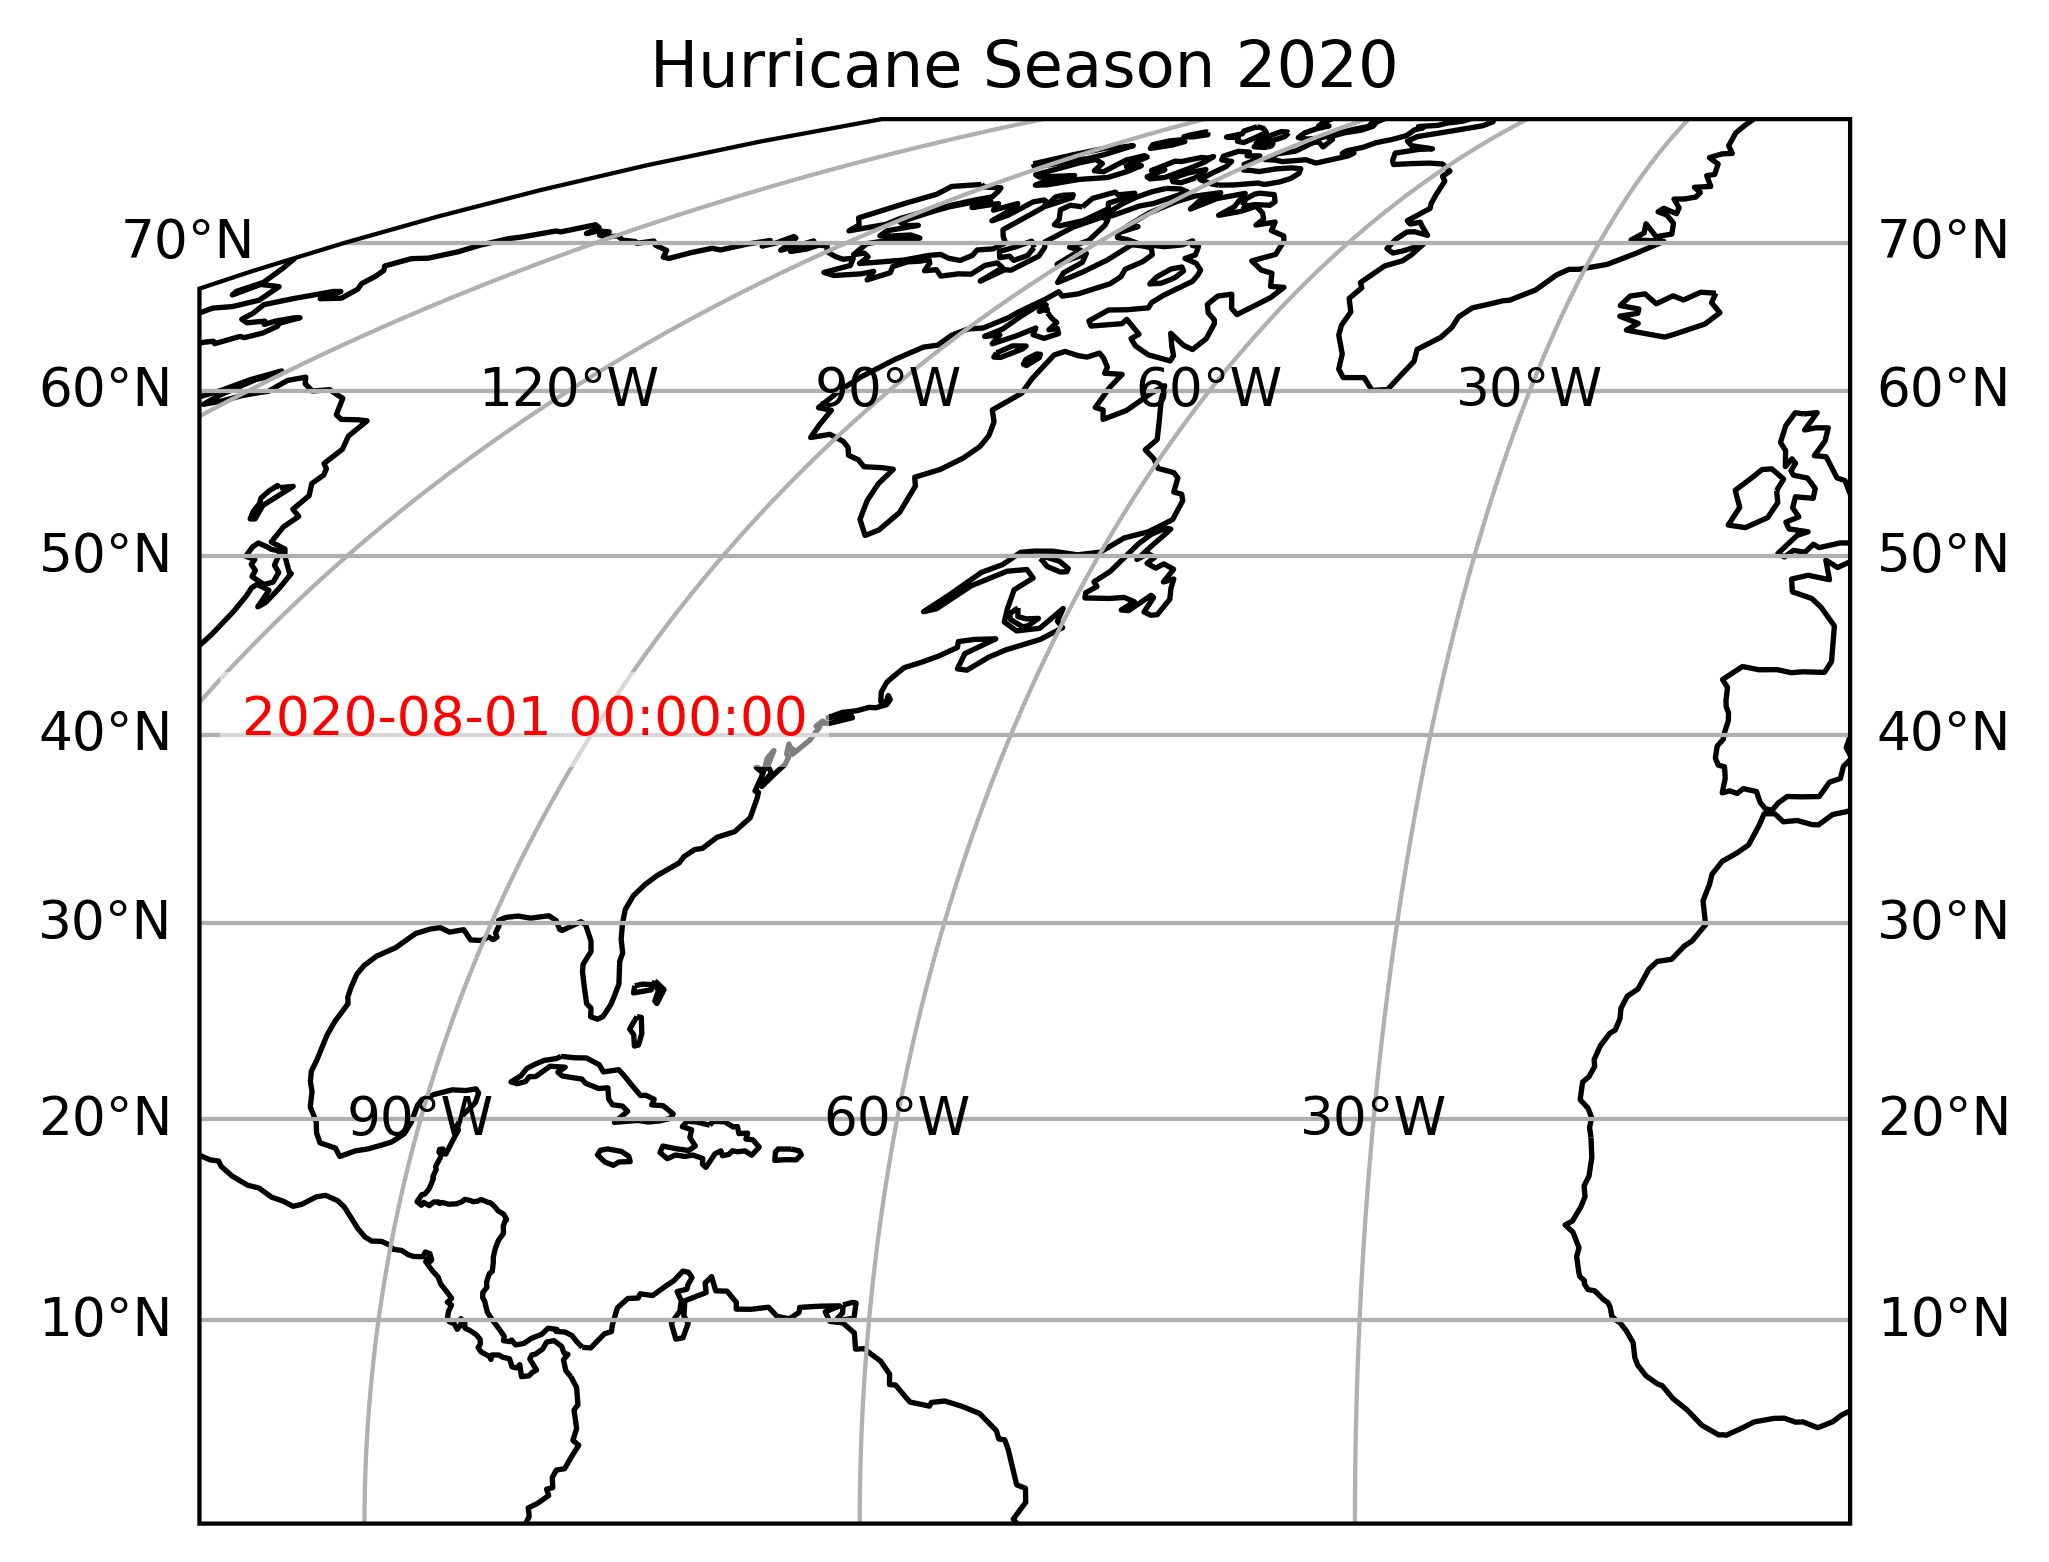

In [6]:
import cartopy.crs as ccrs  # cartopy for projecting our dataset onto different map projections
import matplotlib.pyplot as plt # is an standard plotting library
import matplotlib.animation as animation


DPI = 384
fig = plt.figure(figsize=(7.75, 4.75), dpi=DPI)

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
ax.set_extent([-100, 0, 0, 80], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True)
datetime_label = ax.text(-115, 40, start_dt.strftime('%Y-%m-%d %H:%M:%S'), 
    fontsize=10, 
    color="red", 
    transform=ccrs.PlateCarree(), 
    bbox=dict(facecolor="white", alpha=0.5, edgecolor="none")
)
ax.set_title("Hurricane Season 2020")

Were going to iterate over both, the selected storms and the selected drifters. For each of the trajectories, we plot their starting point and store some data to be utilized for generating the animation.

Lets unpack the data variables from a ragged array (1-d array composed of each rows data variable segment) into a list of row data variable segments.

In [7]:
from clouddrift.ragged import unpack

storm_indices = np.array(range(len(matching_storms.id)))
drifter_indices = np.array(range(len(matching_drifters.id)))

storm_lons = unpack(matching_storms.lon, matching_storms.rowsize, storm_indices)
storm_lats = unpack(matching_storms.lat, matching_storms.rowsize, storm_indices)

drifter_lons = unpack(matching_drifters.lon, matching_drifters["rowsize"], drifter_indices)
drifter_lats = unpack(matching_drifters.lat, matching_drifters["rowsize"], drifter_indices)
drifter_temps = unpack(matching_drifters.temp, matching_drifters["rowsize"], drifter_indices)

Use the unpacked segments and plot the initial starting point of the storm and drifter trajectories (we also do some setup with setting up indexes to make searching later down the line easier).

In [8]:
storm_lines = list()
drifter_lines = list()

for storm_idx in storm_indices:
    selected_lon, selected_lat = storm_lons[storm_idx], storm_lats[storm_idx]
    selected_lon, selected_lat = selected_lon.set_xindex("time"), selected_lat.set_xindex("time")
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="-", linewidth=3,
        transform=ccrs.PlateCarree(),
    )
    storm_lines.append((selected_lon, selected_lat, line[0]))

for drifter_idx in drifter_indices:
    selected_lon, selected_lat, selected_temp = drifter_lons[drifter_idx], drifter_lats[drifter_idx], drifter_temps[drifter_idx]
    selected_lon, selected_lat, selected_temp = (selected_lon.set_xindex("time"), selected_lat.set_xindex("time"), selected_temp.set_xindex("time"))
    line = ax.plot(selected_lon[0], selected_lat[0],
        linestyle="-", linewidth=1,
        transform=ccrs.PlateCarree(),
    )
    drifter_lines.append((selected_lon, selected_lat, selected_temp, line[0]))

Lets now find the upper and lower bounds for the current temperature values being plotted. We'll use this to create a color map to color the drifter trajectories. 

In [9]:
import matplotlib.cm as cm
import matplotlib.colors as colors


min_t = np.nanmin([np.nanmin(temp) for (_, _, temp, _) in drifter_lines])
max_t = np.nanmax([np.nanmax(temp) for (_, _, temp, _) in drifter_lines])

cmap = plt.get_cmap("inferno")
norm = colors.Normalize(vmin=min_t, vmax=max_t)

(min_t, max_t, cmap(norm(80)))

/tmp/ipykernel_60608/408143479.py:5: RuntimeWarning: All-NaN axis encountered
  min_t = np.nanmin([np.nanmin(temp) for (_, _, temp, _) in drifter_lines])
/tmp/ipykernel_60608/408143479.py:6: RuntimeWarning: All-NaN axis encountered
  max_t = np.nanmax([np.nanmax(temp) for (_, _, temp, _) in drifter_lines])


(7.506, 32.754, (0.988362, 0.998364, 0.644924, 1.0))

Lets add the legend for the color bar.

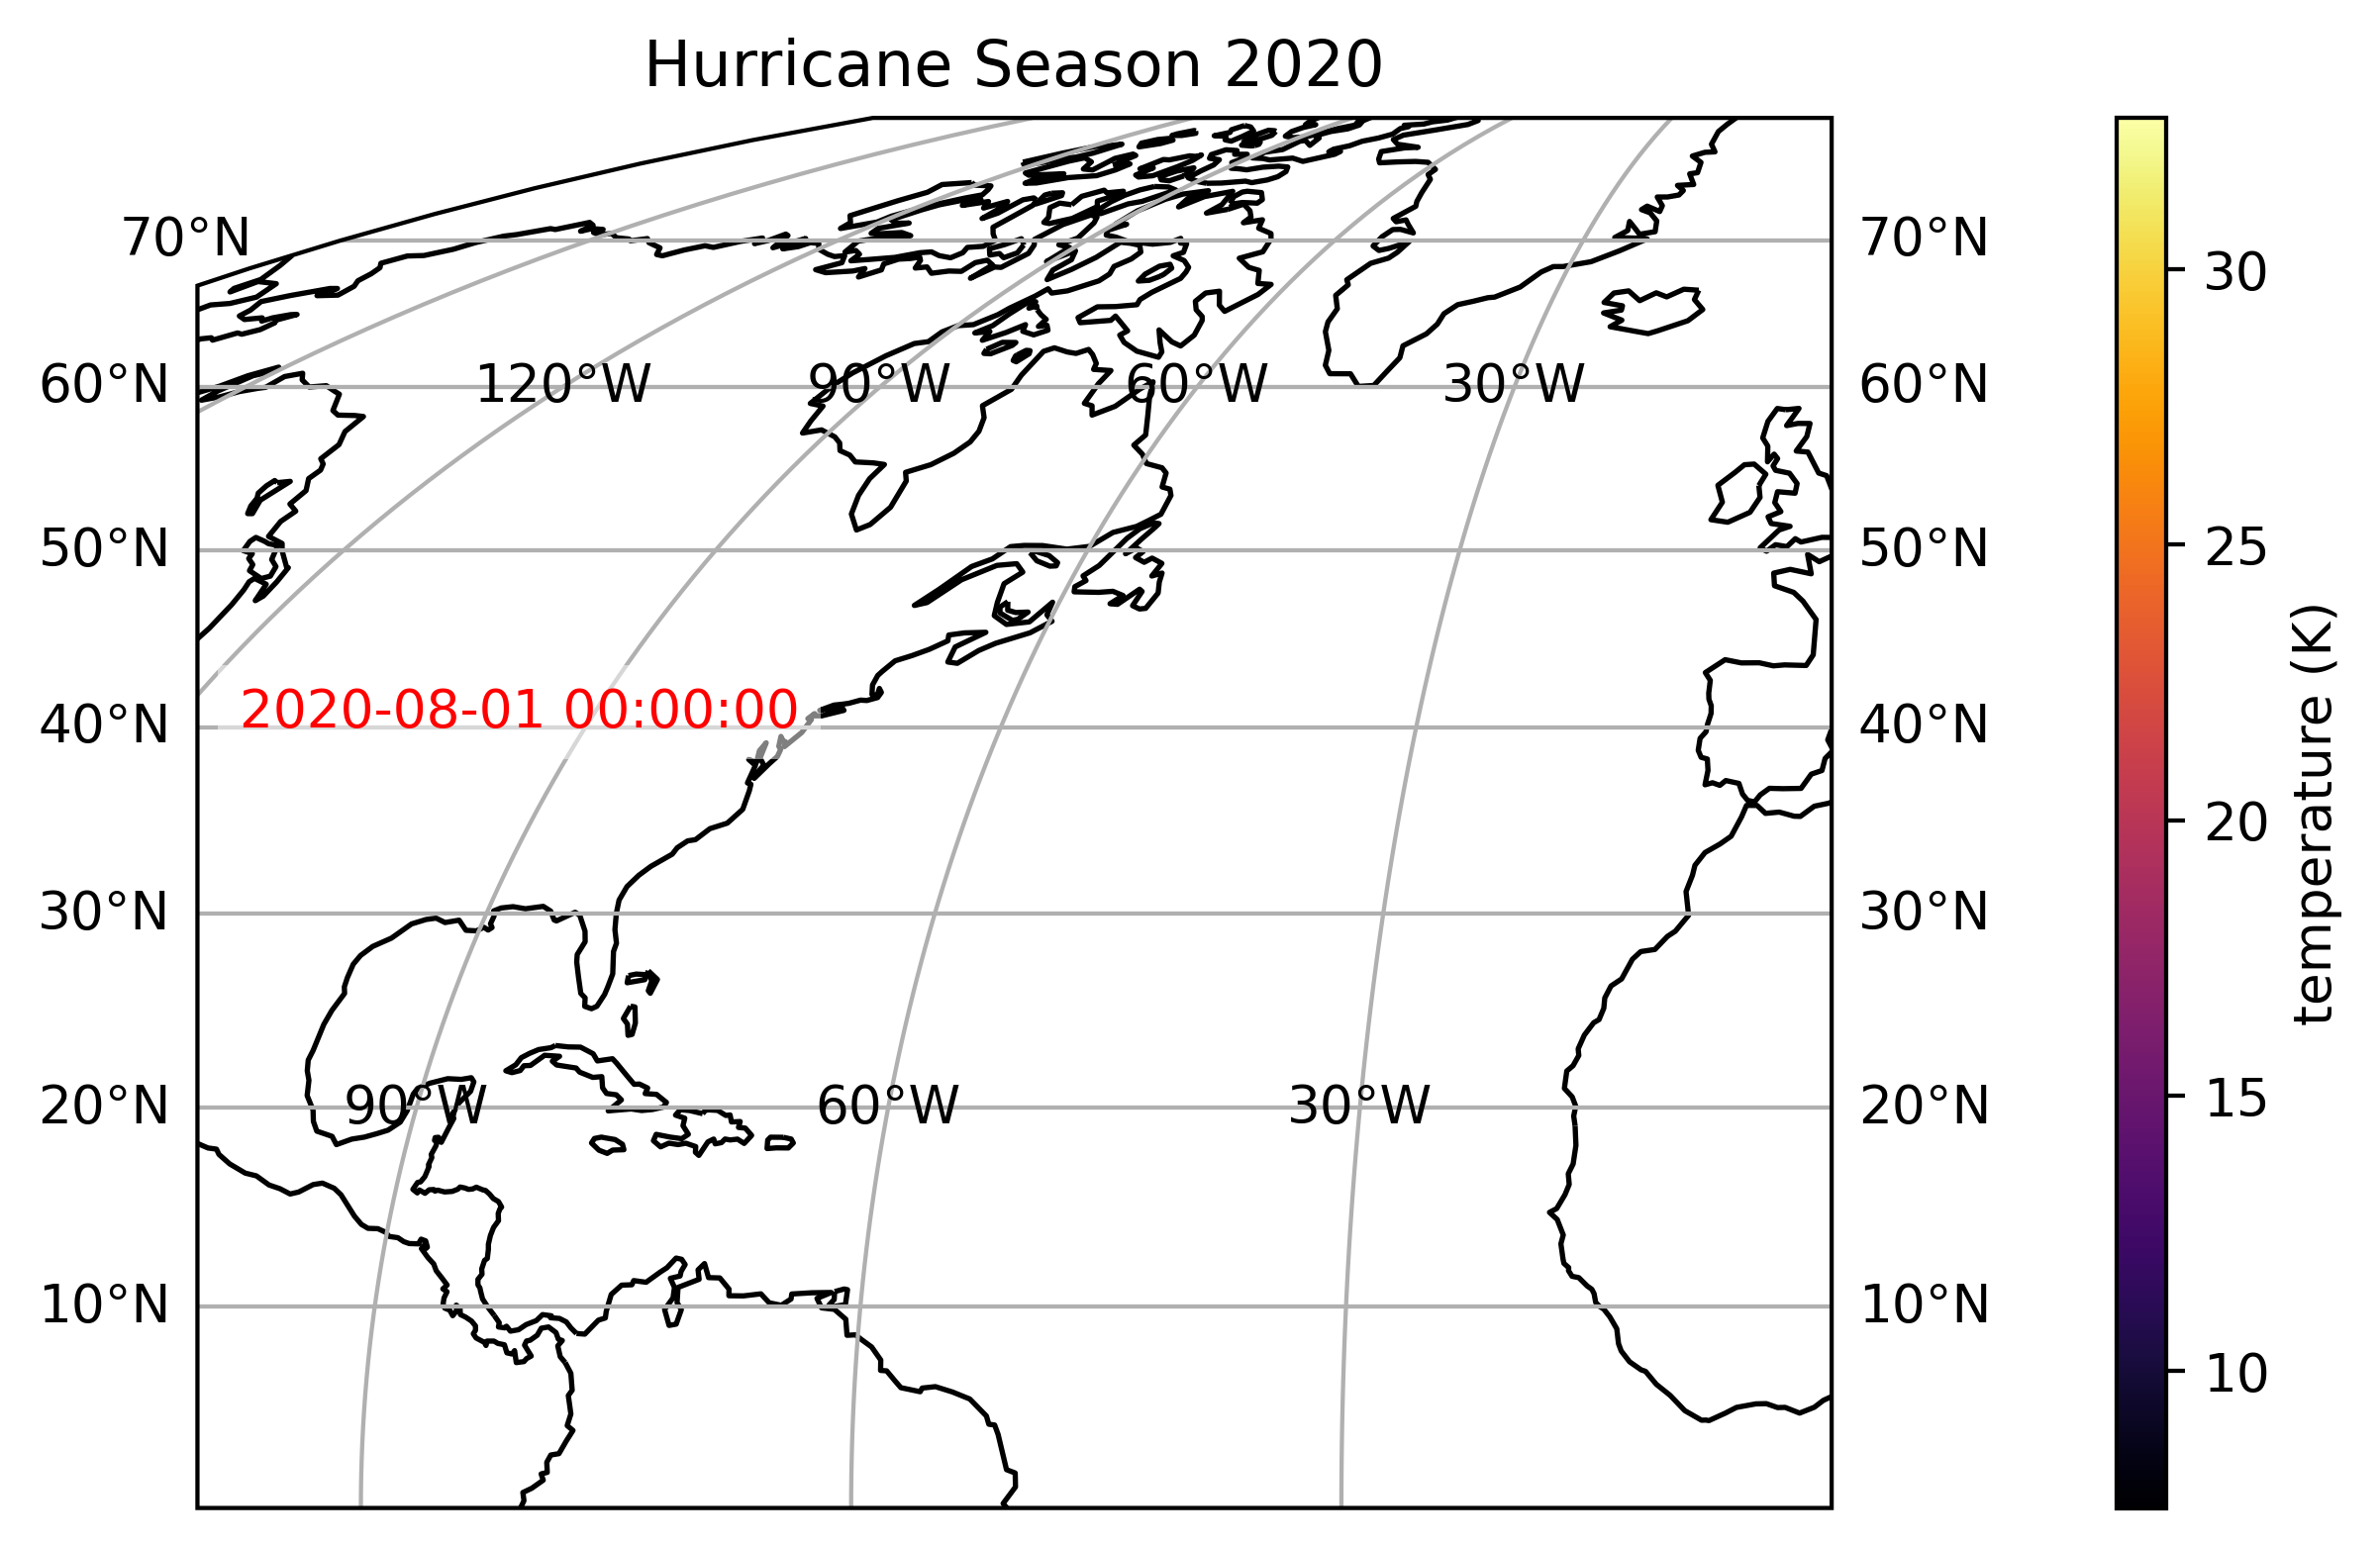

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="3%", pad=0.75, axes_class=plt.Axes)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label="temperature (K)")
fig

Lets take the start and end date we've used for the criteria and generate an range of values that each map uniquely to a frame.

In [11]:
import pandas as pd
frame_count = 500
daterange = pd.date_range(start_dt, end_dt, frame_count)

Lets now generate each frame by selecting the date associated to it which we utilize to update each trajectory with new observations

In [12]:
storm_frames = list()
drifter_frames = list()
frames = dict()
tail_len = 50

for idx, dt in enumerate(daterange):
    if ((idx+1) % 100 == 0):
        print(f"generating index: {idx}")

    storm_updates = list()
    for s_lon, s_lat, s_line in storm_lines:
        sel_d_lon = s_lon.sel(time=slice(start_dt, dt))
        sel_d_lat = s_lat.sel(time=slice(start_dt, dt))
        storm_updates.append((sel_d_lon, sel_d_lat, s_line))

    drifter_updates = list()
    for d_lon, d_lat, d_temp, d_line, in drifter_lines:
        sel_d_lon = d_lon.sel(time=slice(start_dt.timestamp(), dt.timestamp()))
        sel_d_lat = d_lat.sel(time=slice(start_dt.timestamp(), dt.timestamp()))
        sel_d_temp = d_temp.sel(time=slice(start_dt.timestamp(), dt.timestamp()))
        sel_d_lon = sel_d_lon.tail(obs=tail_len)
        sel_d_lat = sel_d_lat.tail(obs=tail_len)
        sel_d_temp = sel_d_temp.tail(obs=tail_len)
        drifter_updates.append((sel_d_lon, sel_d_lat, sel_d_temp, d_line))

    frames[dt] = dict(drifter_updates=drifter_updates, storm_updates=storm_updates)

generating index: 99
generating index: 199
generating index: 299
generating index: 399
generating index: 499


We define an update function that, using the frame index, selects the frame and updates each trajectories longitude and latitude (and also temperature for the case of the drifters)

In [13]:

sorted_dates = sorted(frames.keys())

def update(frame_idx):
    frame_dt = sorted_dates[frame_idx]
    frame = frames[frame_dt]
    drifter_updates = frame["drifter_updates"]
    storm_updates = frame["storm_updates"]

    datetime_label.set_text(frame_dt.strftime('%Y-%m-%d %H:%M:%S'))

    updated_lines = list()
    for x_update, y_update, line in storm_updates:
        line.set_xdata(x_update)
        line.set_ydata(y_update)
        updated_lines.append(line)

    for x_update, y_update, temps, line in drifter_updates:
        line.set_xdata(x_update)
        line.set_ydata(y_update)
        if len(temps.data) > 0:
            line.set_color(cmap(norm(np.nanmean(temps))))
        updated_lines.append(line)
    return updated_lines

ani = animation.FuncAnimation(fig=fig, func=update, frames=frame_count, interval=50)

Now generate the animation!

In [14]:
import warnings
warnings.filterwarnings("ignore") # bad practice and should never be used but helps us keep the output clean and should only ever be used in experimental/sample code.

ani.save("storm_drifters.gif", dpi=DPI, progress_callback=lambda i, n: print(f'Saving frame {i}/{n}'))

Saving frame 0/500
Saving frame 1/500
Saving frame 2/500
Saving frame 3/500
Saving frame 4/500
Saving frame 5/500
Saving frame 6/500
Saving frame 7/500
Saving frame 8/500
Saving frame 9/500
Saving frame 10/500
Saving frame 11/500
Saving frame 12/500
Saving frame 13/500
Saving frame 14/500
Saving frame 15/500
Saving frame 16/500
Saving frame 17/500
Saving frame 18/500
Saving frame 19/500
Saving frame 20/500
Saving frame 21/500
Saving frame 22/500
Saving frame 23/500
Saving frame 24/500
Saving frame 25/500
Saving frame 26/500
Saving frame 27/500
Saving frame 28/500
Saving frame 29/500
Saving frame 30/500
Saving frame 31/500
Saving frame 32/500
Saving frame 33/500
Saving frame 34/500
Saving frame 35/500
Saving frame 36/500
Saving frame 37/500
Saving frame 38/500
Saving frame 39/500
Saving frame 40/500
Saving frame 41/500
Saving frame 42/500
Saving frame 43/500
Saving frame 44/500
Saving frame 45/500
Saving frame 46/500
Saving frame 47/500
Saving frame 48/500
Saving frame 49/500
Saving fra